In [12]:
using Random
using StatsBase
using Distributions
using StatsPlots
using StatsFuns
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 9.1 Good King Markov and his island kingdom

Code 9.1

In [2]:
Random.seed!(1)
num_weeks = 10^5
positions = []
current = 10

for i ∈ 1:num_weeks
    # record current position
    push!(positions, current)
    # flip coin to generate proposal
    proposal = current + sample([-1, 1])
    # handle loops around
    proposal < 1 && (proposal = 10)
    proposal > 10 && (proposal = 1)
    # move?
    prob_move = proposal / current
    rand() < prob_move && (current = proposal)
end

Code 9.2

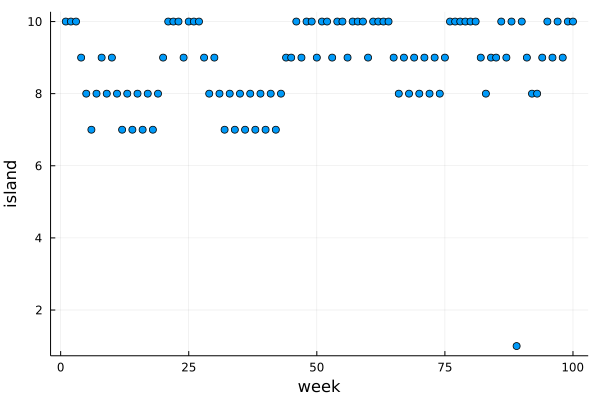

In [3]:
scatter(positions[1:100], xlab="week", ylab="island")

Code 9.3

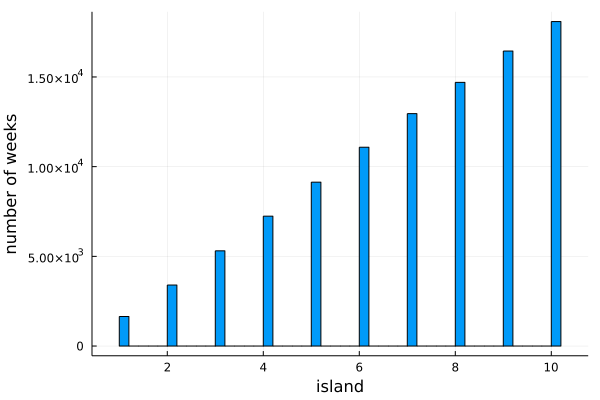

In [4]:
histogram(positions, xlab="island", ylab="number of weeks")

# 9.2 Metropolis algorithms

Code 9.4

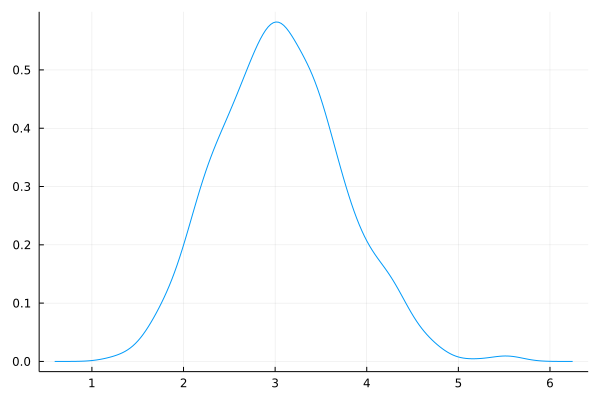

In [5]:
D = 10
T = 1000
Y = rand(MvNormal(zeros(D), ones(D)), T)
Rd = sqrt.(sum.(eachcol(Y.^2)))
density(Rd)

# 9.3 Hamiltonian Monte Carlo

Code 9.5

In [6]:
Random.seed!(7)

x = rand(Normal(), 50)
y = rand(Normal(), 50)
x = standardize(ZScoreTransform, x)
y = standardize(ZScoreTransform, y);

In [7]:
function U(q::Vector{Float64}; a=0, b=1, k=0, d=1)::Float64
    μy, μx = q
    U = sum(normlogpdf.(μy, 1, y)) + sum(normlogpdf.(μx, 1, x)) 
    U += normlogpdf(a, b, μy) + normlogpdf(k, d, μx)
    -U
end

U (generic function with 1 method)

Code 9.6

In [8]:
function ∇U(q::Vector{Float64}; a=0, b=1, k=0, d=1)::Vector{Float64}
    μy, μx = q
    G₁ = sum(y .- μy) + (a - μy) / b^2  # ∂U/∂μy
    G₂ = sum(x .- μx) + (k - μx) / d^2  # ∂U/∂μx
    [-G₁, -G₂]
end

∇U (generic function with 1 method)

Code 9.8, 9.9, 9.10 (before 9.7 to define HMC2 funcition)

In [10]:
function HMC2(U, ∇U, ϵ::Float64, L::Int, current_q::Vector{Float64})
    q = current_q
    p = rand(Normal(), length(q))  # random flick - p is momentum
    current_p = p
    
    # make a half step for momentum at the beginning
    p -= ϵ .* ∇U(q) ./ 2
    
    # initialize bookkeeping - saves trajectory
    qtraj = [q]
    ptraj = [p]
    
    # Alternate full steps for position and momentum
    for i ∈ 1:L
        q += @. ϵ * p  # full step for the position
        # make a full step for the momentum except at the end of trajectory
        if i != L
            p -= ϵ * ∇U(q)
            push!(ptraj, p)
        end
        push!(qtraj, q)
    end
    
    # Make a half step for momentum at the end
    p -= ϵ * ∇U(q) / 2
    push!(ptraj, p)
    
    # negate momentum at the end of trajectory to make the proposal symmetric
    p = -p
    
    # evaluate potential and kinetic energies at the start and the end of trajectory
    current_U = U(current_q)
    current_K = sum(current_p.^2)/2
    proposed_U = U(q)
    proposed_K = sum(p.^2)/2
    
    # accept or reject the state at the end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = (rand() < exp(current_U - proposed_U + current_K - proposed_K))

    if accept
        current_q = q
    end
    
    (q=current_q, traj=qtraj, ptraj=ptraj, accept=accept)
end

HMC2 (generic function with 1 method)

Code 9.7

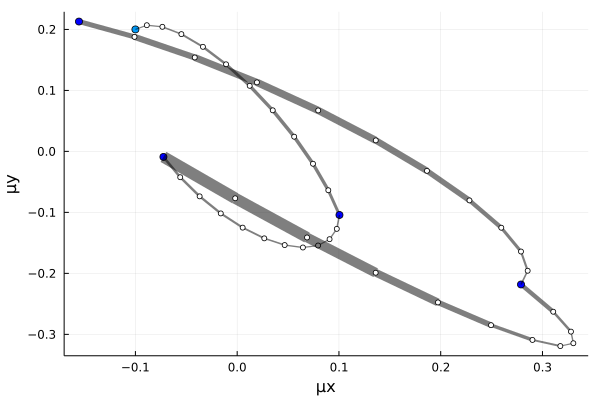

In [13]:
Random.seed!(1)
Q = (q=[-0.1, 0.2],)
pr = 0.3
step = 0.03
L = 11
n_samples = 4
p = scatter([Q.q[1]], [Q.q[2]], xlab="μx", ylab="μy")

for i ∈ 1:n_samples
    Q = HMC2(U, ∇U, step, L, Q.q)
    if n_samples < 10 
        cx, cy = [], []
        for j ∈ 1:L
            K0 = sum(Q.ptraj[j].^2)/2
            plot!(
                [Q.traj[j][1], Q.traj[j+1][1]],
                [Q.traj[j][2], Q.traj[j+1][2]],
                lw=1+2*K0,
                c=:black,
                alpha=0.5
            )
            push!(cx, Q.traj[j+1][1])
            push!(cy, Q.traj[j+1][2])
        end
        scatter!(cx, cy, c=:white, ms=3)
    end
    scatter!([Q.q[1]], [Q.q[2]], shape=(Q.accept ? :circle : :rect), c=:blue)
end
p

# 9.4 Easy HMC: ulam